In [1]:
# plot the input for bootstrap.df as cloud (instead of scatter)

import itertools

import matplotlib.collections as mcollections
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import xarray as xr

import tc_cost.bootstrap.df as bs_df
import tc_cost.util.constants as u_const
import tc_cost.util.data as u_data
import tc_cost.util.io as u_io

In [2]:
use_ols = True
use_temp = True
suffix = f"{'_ols' if use_ols else ''}{'_temp' if use_temp else ''}"

timehorizon = 8
iso = "GLB"

In [3]:
ds_losses = bs_df.load_loss_data(timehorizon, iso, suffix).compute()
ds_losses['gmt'] = xr.open_dataset(u_const.GMT_NC)['gmt']

In [4]:
def compute_confidence_ellipse(x, y, n_std=3.0):
    # explicit formula for eigenvalues of a 2x2 covariance matrix
    cov = np.cov(x, y)
    pearson = cov[0, 1] / (
        1 if cov[0, 1] == 0
        else np.sqrt(cov[0, 0] * cov[1, 1])
    )
    width = 2 * np.sqrt(1 + pearson)
    height = 2 * np.sqrt(1 - pearson)
    transform = (
        mtransforms.Affine2D()
        .rotate_deg(45)
        .scale(*[np.sqrt(cov[i, i]) * n_std for i in [0, 1]])
        .translate(np.mean(x), np.mean(y))
    )
    return width, height, transform


def ellipse_patch(ax, width, height, transform, **kwargs):
    ellipse = mpatches.Ellipse(
        (0, 0), width=width, height=height, **kwargs,
    )
    ellipse.set_transform(transform + ax.transData)
    return ellipse

In [5]:
extent = (0.8, 4.9, -0.011, 0.0035)
bins = (
    np.linspace(extent[0], extent[1], 100),
    np.linspace(extent[2], extent[3], 40),
)

conf_ellipses = {}
histograms = {}
for rcp in ds_losses["rcp"].values:
    ds_sel = ds_losses.sel(rcp=rcp)
    x = (
        ds_sel["gmt"]
        .broadcast_like(ds_sel["gdppc_growth_cost"])
        .values.ravel()
    )
    y = ds_sel["gdppc_growth_cost"].values.ravel()
    conf_ellipses[rcp] = compute_confidence_ellipse(x, y, n_std=2.0)
    histograms[rcp] = np.histogram2d(x, y, bins=bins, density=True)[0]
for s, q in {"lo": 0.05, "hi": 0.95}.items():
    ds_losses[f"cost_{s}"] = (
        ds_losses["gdppc_growth_cost"]
        .quantile(q=q, dim=["SSP", "realisation", "elt"])
    )
ds_losses["cost_rng"] = (
    ds_losses["cost_hi"] - ds_losses["cost_lo"]
)
ds_losses["cost_mid"] = 0.5 * (
    ds_losses["cost_lo"] + ds_losses["cost_hi"]
)

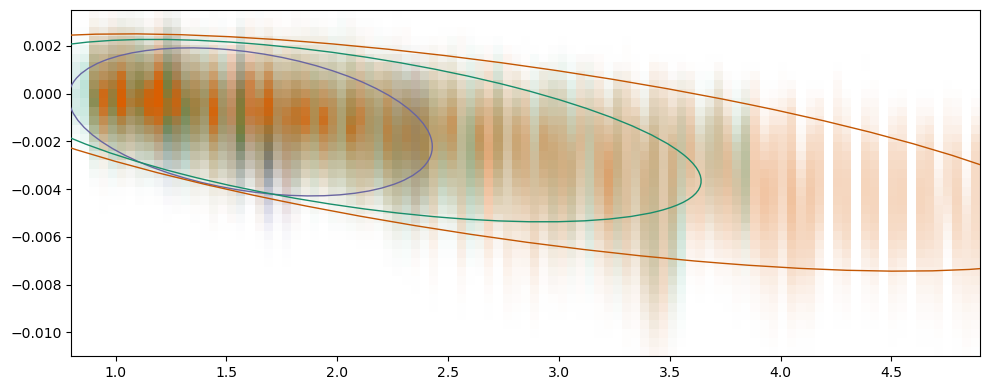

In [6]:
plt.close("all")
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

rcp_colors = {
    f"rcp{rcp}": mcolors.to_rgba(u_const.L_RCP_COLORS[f"rcp{rcp}"])
    for rcp in ["26", "60", "85"]
}

rcp_cmaps = {
    rcp: mcolors.LinearSegmentedColormap.from_list(rcp, [
        (col[:3] + (f,))
        for f in [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0, 1.0]
    ])
    for rcp, col in rcp_colors.items()
}

# one of "scatter", "histogram", or "ellipses"
plot_mode = "histogram"

for rcp in ds_losses["rcp"].values:
    ax.add_patch(ellipse_patch(
        ax, *conf_ellipses[rcp],
        facecolor='none',
        edgecolor=tuple(0.9 * v for v in rcp_colors[rcp][:3]) + (1.0,),
        linewidth=1,
        zorder=100,
    ))

    if plot_mode == "scatter":
        ds_sel = (
            ds_losses.mean(dim=["SSP", "elt", "realisation"])
            .sel(rcp=rcp)
        )
        y = ds_sel["gdppc_growth_cost"].values.ravel()
        x = ds_sel["gmt"].values.ravel()
        ax.scatter(
            x, y,
            s=40, alpha=0.3,
            color=rcp_colors[rcp],
            edgecolors='none',
        )
    elif plot_mode == "histogram":
        ax.imshow(
            histograms[rcp].T,
            origin="lower",
            extent=extent,
            aspect="auto",
            cmap=rcp_cmaps[rcp],
            interpolation="nearest",
        )
    else:
        ds_sel = ds_losses.sel(rcp=rcp)
        heights = ds_sel["cost_rng"].values.ravel()
        widths = np.full_like(heights, 0.04)
        angles = np.zeros_like(heights)
        offsets = np.stack([
            ds_sel["gmt"].values.ravel(),
            ds_sel["cost_mid"].values.ravel(),
        ], axis=1)
        ax.add_collection(mcollections.EllipseCollection(
            widths, heights, angles,
            units="xy",
            offsets=offsets,
            offset_transform=ax.transData,
            facecolor=rcp_colors[rcp][:3] + (0.1,),
            edgecolor="none",
            zorder=1,
        ))

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

fig.tight_layout()

In [7]:
scc_dir = u_const.BOOTSTRAP_DIR / "scc"
ssp = "SSP2"
all_scc_paths = scc_dir.glob(f"{ssp}-{timehorizon}-*-{rcp}-*{suffix}.nc")
l_countries = ["USA", "TWN"] # sorted(set(p.stem.split("-")[-1].strip(suffix) for p in all_scc_paths))

ds_scc = xr.open_mfdataset([
    [
        scc_dir / f"{ssp}-{timehorizon}-{gcm}-{rcp}-{iso}{suffix}.nc"
        for iso in l_countries
    ] for gcm in u_const.L_GCM
], combine="nested", concat_dim=["gcm", "ISO"], parallel=True)
ds_scc['ISO'] = ("ISO", l_countries)
for v in ["rho", "eta"]:
    ds_scc[v] = ds_scc[v].isel({d: 0 for d in ds_scc[v].dims if d != "dr"})
ds_scc = ds_scc.chunk(dict(gcm=-1))
ds_scc["scc_tc"] = ds_scc["scc"] - ds_scc["scc_temp"]
ds_scc = ds_scc.chunk(dict(ISO=-1))